In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud
from collections import Counter
import os
from datetime import datetime

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195790 sha256=4847be9b198fa74314b2598af25734b7735dc180a65207077665b23a7433b598
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
def open_csv(file_name):
    file = os.path.abspath(file_name)
    df = pd.read_csv(file, low_memory= False)
    return df
df = open_csv('movies_metadata.csv')
df = df.drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587])
df['id'] = df['id'].astype('int64')
df = df[~df['original_title'].duplicated()]
df['original_language'] = df['original_language'].fillna('')
df = df.reset_index(drop=True)
df.head(5)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0


In [ ]:
df['genres']

In [ ]:
df_title = df[['id', 'original_title']]
df_title = df_title.rename(columns={'id': 'movieId'})
df_title.head()


,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43371 entries, 0 to 43370
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 43371 non-null  object 
 1   budget                43371 non-null  object 
 2   genres                43371 non-null  object 
 3   id                    43371 non-null  int64  
 4   original_language     43371 non-null  object 
 5   original_title        43371 non-null  object 
 6   overview              42441 non-null  object 
 7   popularity            43368 non-null  object 
 8   production_companies  43368 non-null  object 
 9   production_countries  43368 non-null  object 
 10  release_date          43287 non-null  object 
 11  revenue               43368 non-null  float64
 12  runtime               43118 non-null  float64
 13  spoken_languages      43368 non-null  object 
 14  tagline               19345 non-null  object 
 15  vote_average       

In [ ]:
df.shape

(43371, 17)

In [ ]:
df['genres'] = df['genres'].fillna('[]')
genre_type = []
for genre_name in df['genres']:
    genre_name = literal_eval(genre_name)
    genre_type.append([d['name'] for d in genre_name])

df['genre_type'] = genre_type
df.head(5)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,genre_type
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0,"[Animation, Comedy, Family]"
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[Adventure, Fantasy, Family]"
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[Romance, Comedy]"
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[Comedy, Drama, Romance]"
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,[Comedy]


The number of unique language is 89
But three are like this[]
After removing the float {'en': 30420, 'fr': 2371, 'it': 1517, 'ja': 1334, 'de': 1044, 'es': 976, 'ru': 816, 'hi': 496, 'ko': 443, 'zh': 406, 'sv': 378, 'cn': 312, 'pt': 308, 'fi': 293, 'nl': 236, 'da': 220, 'pl': 215, 'tr': 148, 'cs': 128, 'el': 111, 'fa': 100, 'no': 100, 'hu': 99, 'ta': 77, 'th': 74, 'he': 67, 'sr': 63, 'ro': 57, 'te': 44, 'ar': 38, 'ml': 36, 'xx': 32, 'bn': 29, 'hr': 28, 'mr': 25, 'is': 24, 'et': 24, 'tl': 21, 'id': 20, 'lv': 18, 'ka': 18, 'sl': 16, 'uk': 16, 'bs': 13, 'ca': 12, '': 11, 'bg': 10, 'ab': 10, 'vi': 10, 'sk': 9, 'lt': 8, 'ur': 8, 'sh': 5, 'ms': 5, 'sq': 5, 'nb': 5, 'mk': 5, 'wo': 5, 'kk': 3, 'kn': 3, 'ku': 3, 'eu': 3, 'bm': 3, 'ky': 3, 'lo': 2, 'ne': 2, 'iu': 2, 'am': 2, 'pa': 2, 'mn': 2, 'ps': 2, 'bo': 2, 'af': 2, 'lb': 1, 'cy': 1, 'hy': 1, 'mt': 1, 'sm': 1, 'uz': 1, 'gl': 1, 'jv': 1, 'tg': 1, 'zu': 1, 'la': 1, 'ay': 1, 'fy': 1, 'rw': 1, 'qu': 1, 'si': 1}


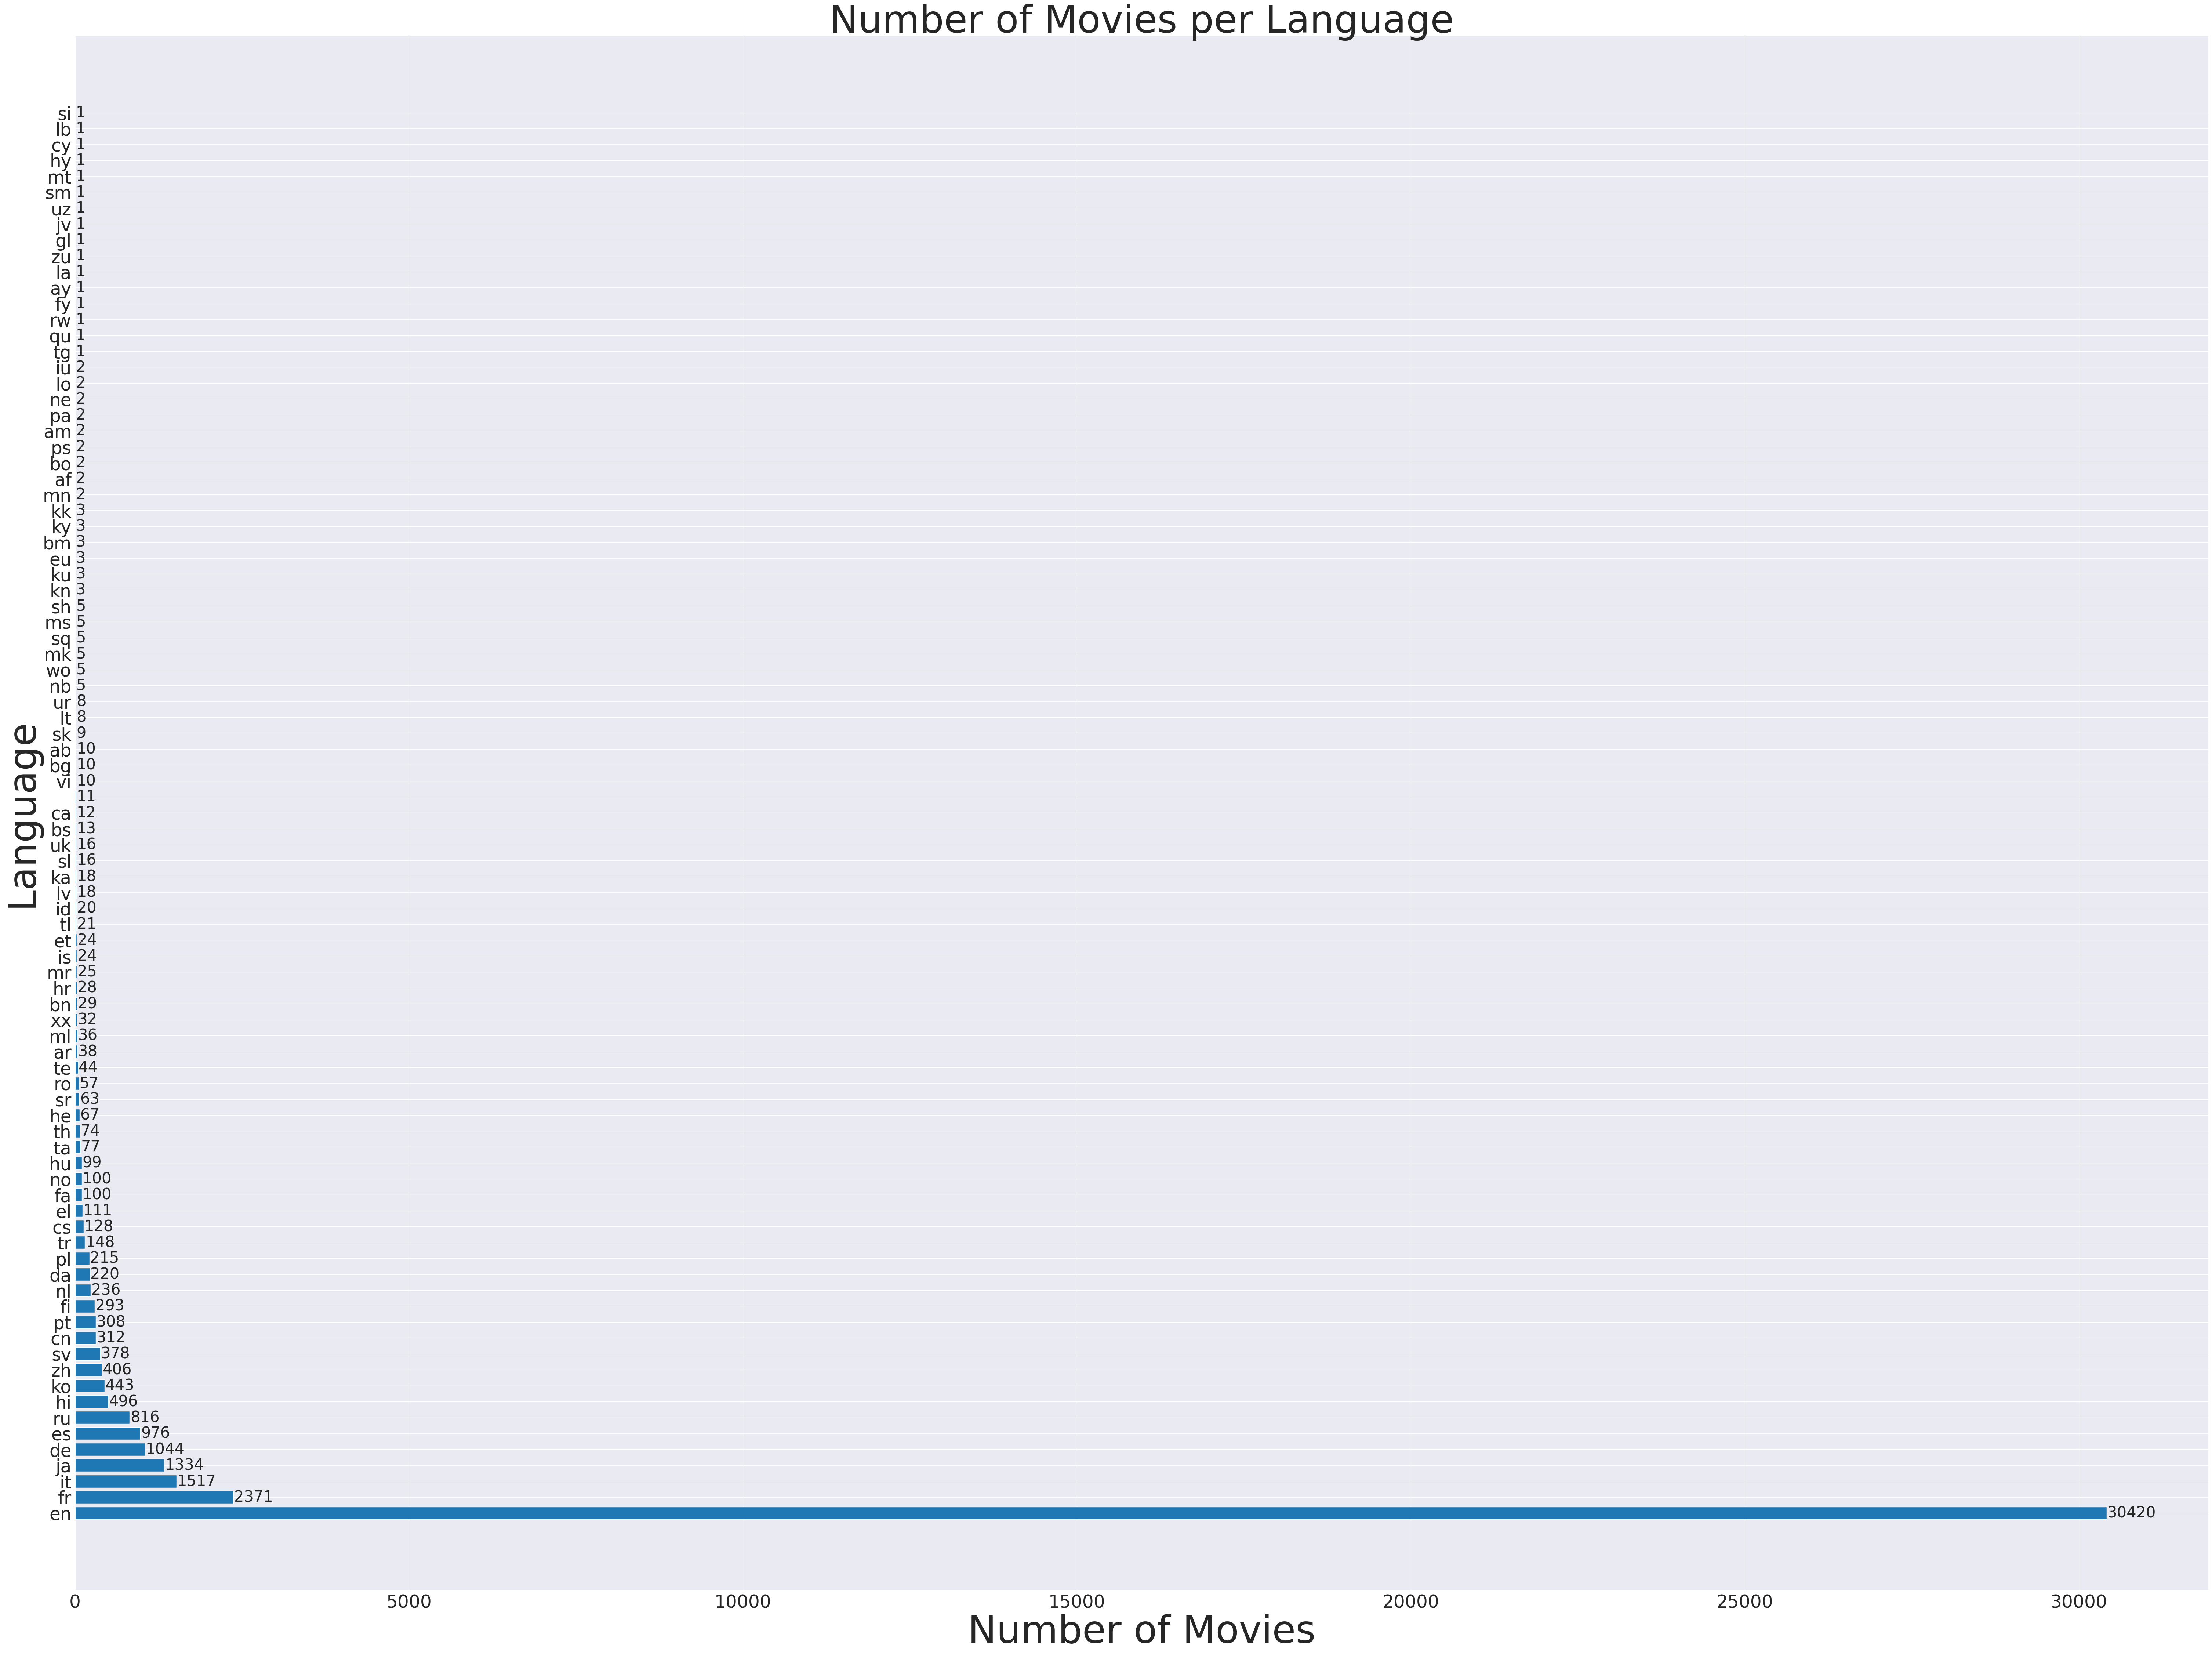

In [ ]:

unique_lang = df['original_language'].nunique()
lang_count = df['original_language'].value_counts()
print(f"The number of unique language is {unique_lang}")
lang_count = dict(lang_count)

float_lang =[]
for key,value in lang_count.items():
    if isinstance(key,str) and '.' in key:
        float_lang.append((key,value))
print(f"But three are like this{float_lang}")
for key, value in float_lang:
    del lang_count[key]
print(f"After removing the float {lang_count}")


lang_counts = pd.DataFrame({'language': lang_count.keys(), 'count': lang_count.values()})

lang_counts = lang_counts.sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize=(75, 55))
ax.barh(lang_counts['language'], lang_counts['count'])

for i, count in enumerate(lang_counts['count']):
    ax.text(count+10, i, str(count), ha='left', va='center', fontsize=30)

ax.set_title('Number of Movies per Language', fontsize=75)
ax.set_xlabel('Number of Movies', fontsize=75)
ax.set_ylabel('Language', fontsize=75)

ax.tick_params(axis='both', labelsize=35)

plt.show()


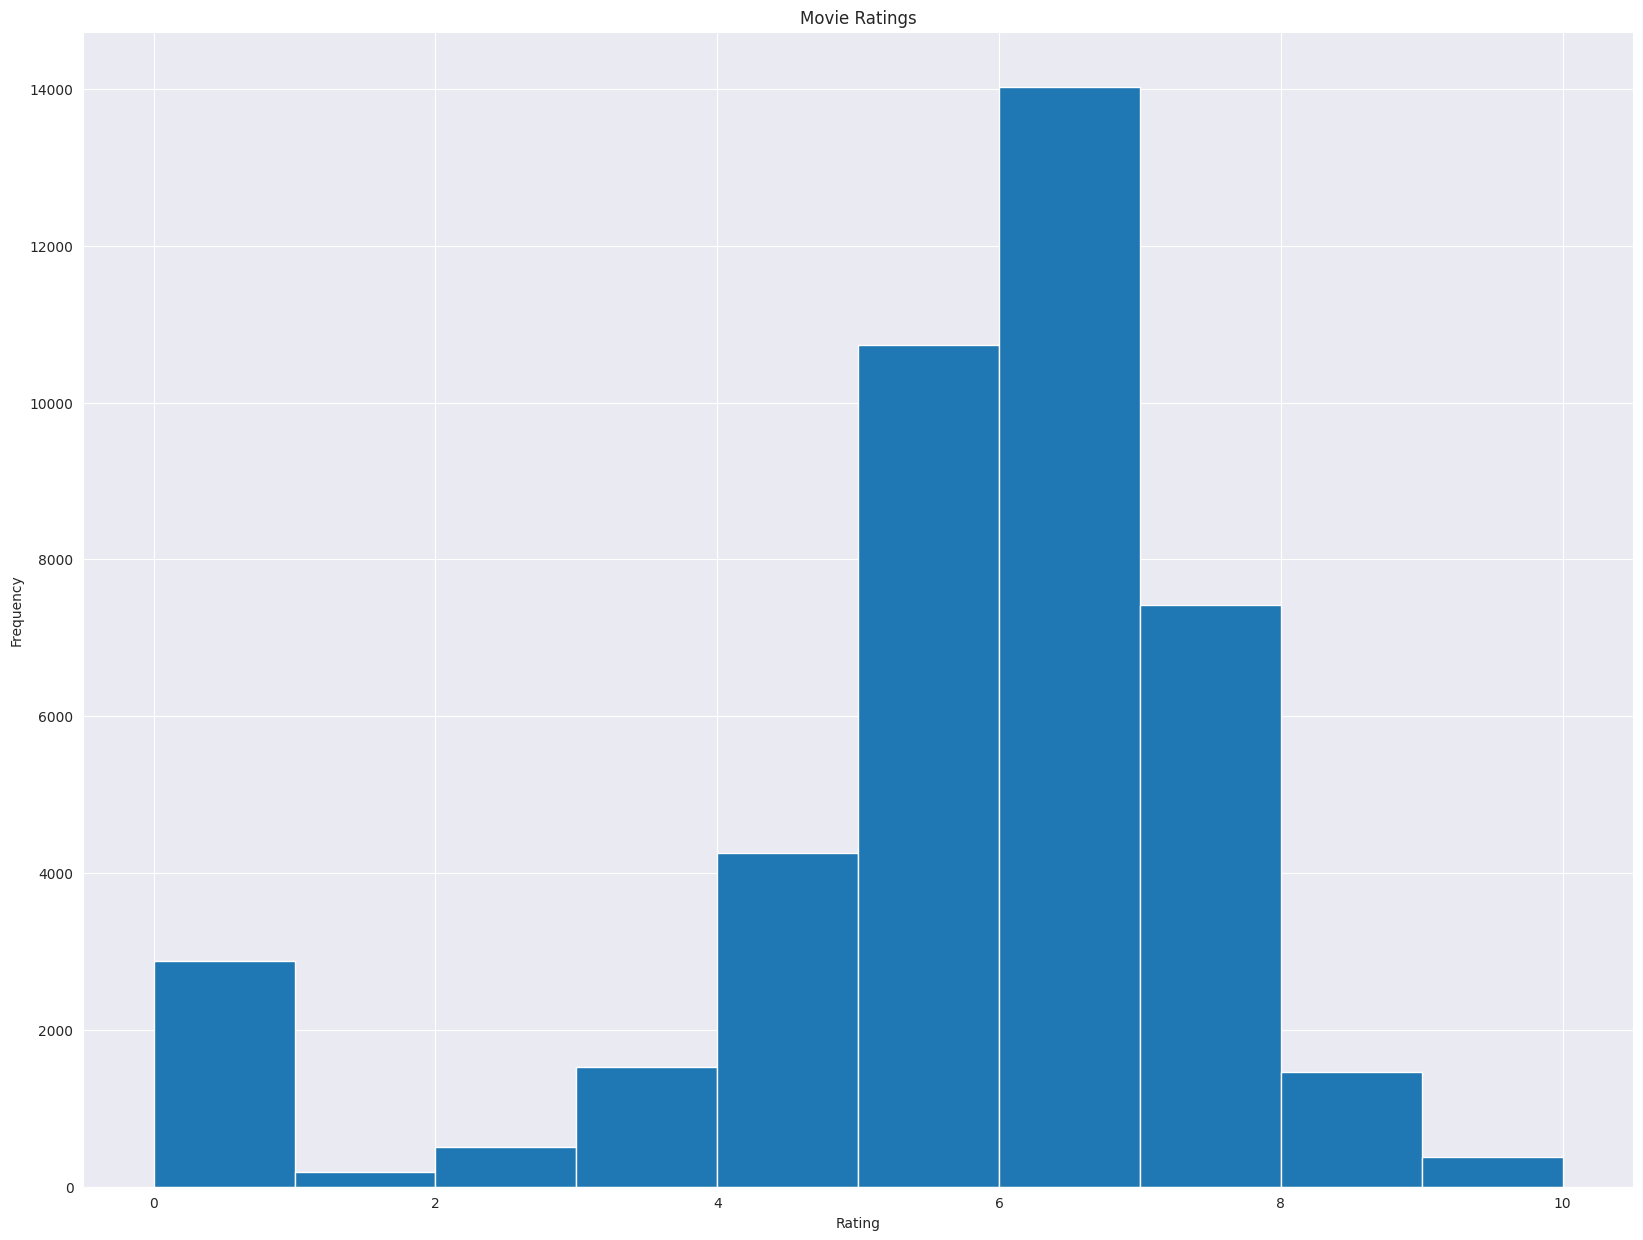

In [ ]:
rating = df['vote_average']
plt.figure(figsize=(20,15))
plt.hist(rating, bins=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Ratings')
plt.show()

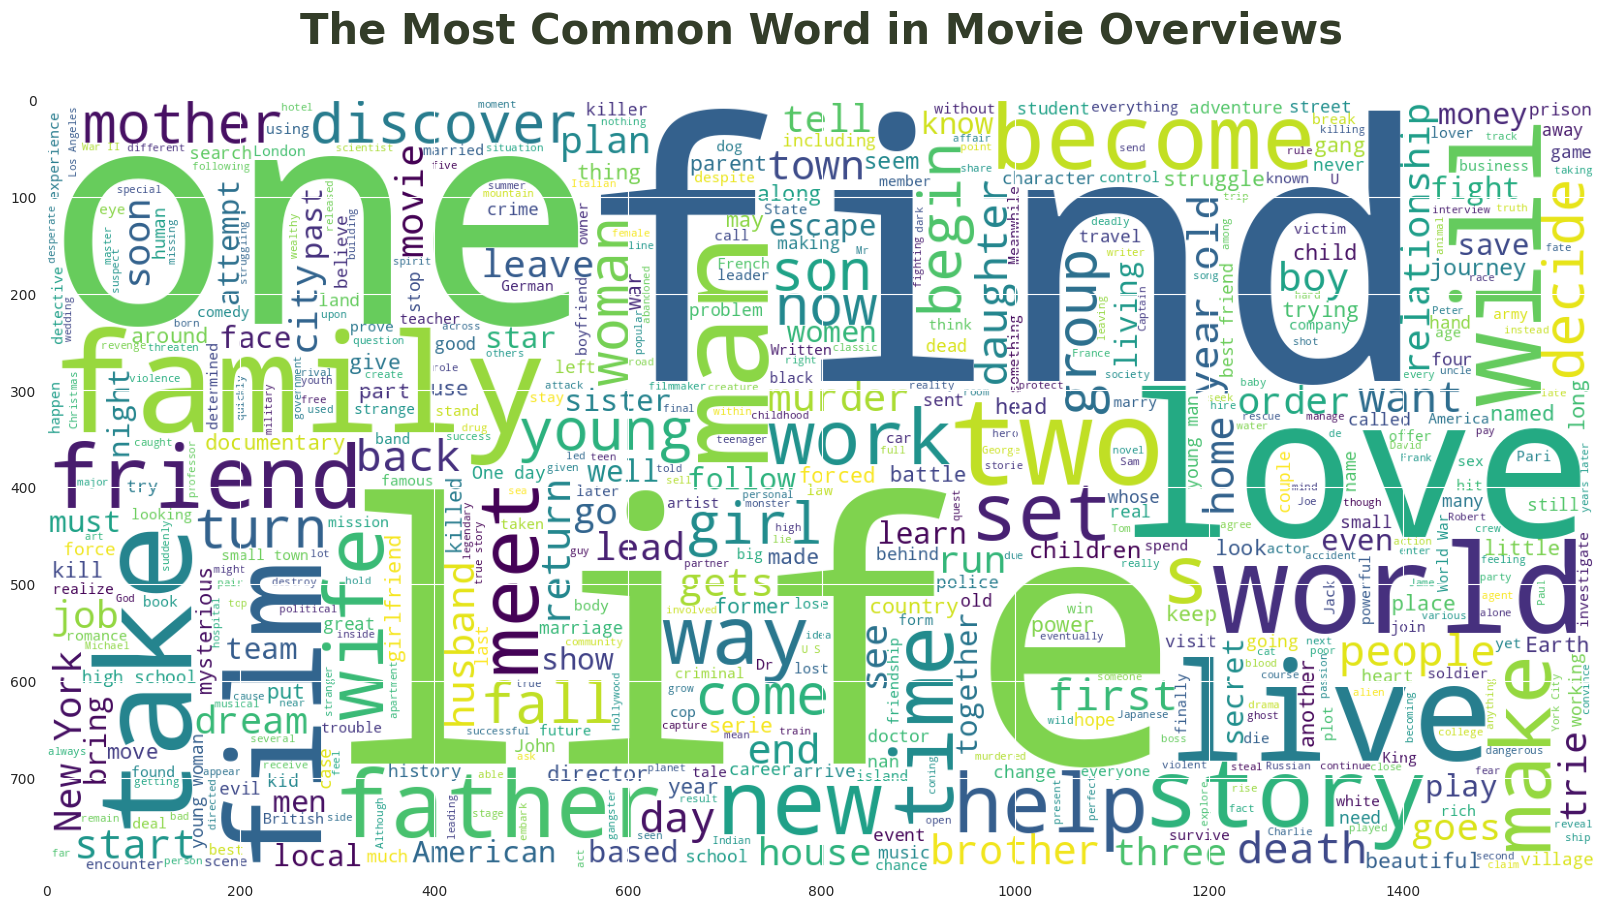

In [ ]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
text = df['overview'].apply(str).tolist()

wc = WordCloud(max_words=1000, min_font_size=10,
                height=800, width=1600, background_color="white").generate(' '.join(text))

plt.imshow(wc)

(-1.25, 1.25, -1.25, 1.25)

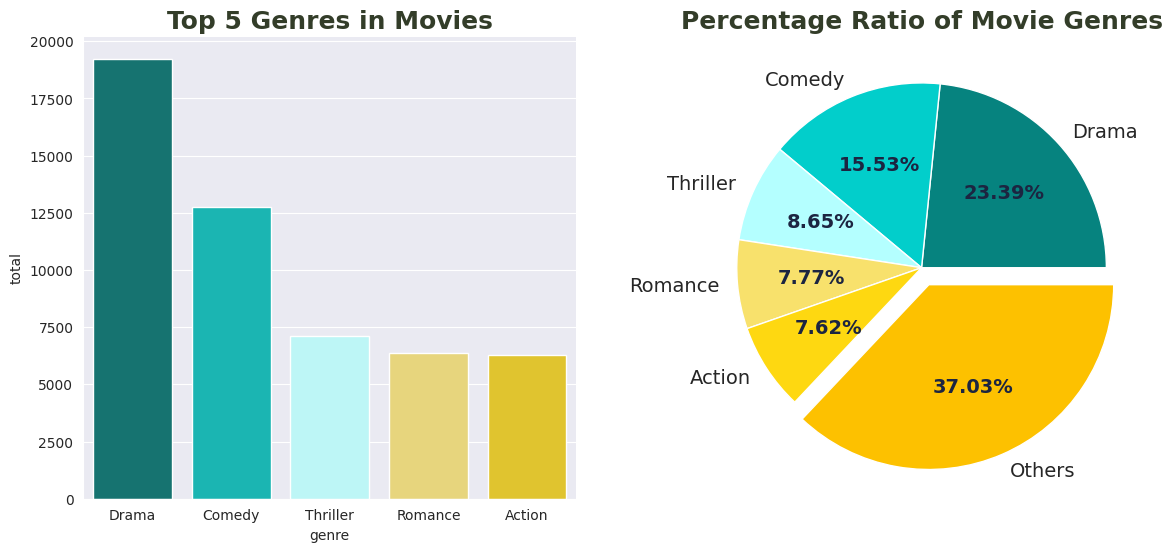

In [ ]:
genres_list = []
for lst in df['genre_type']:
    genres_list.extend(lst)
genres_list = [str(genre) for genre in genres_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])
for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

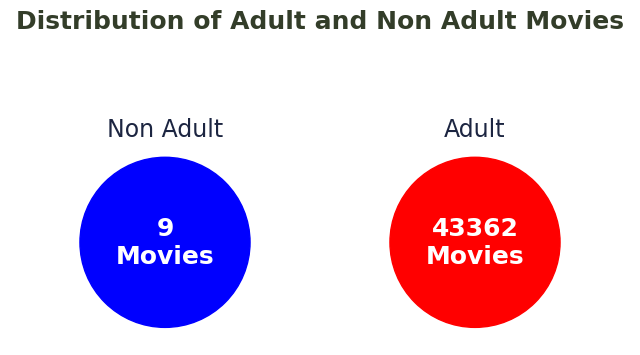

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['blue', 'red'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')
plt.show()


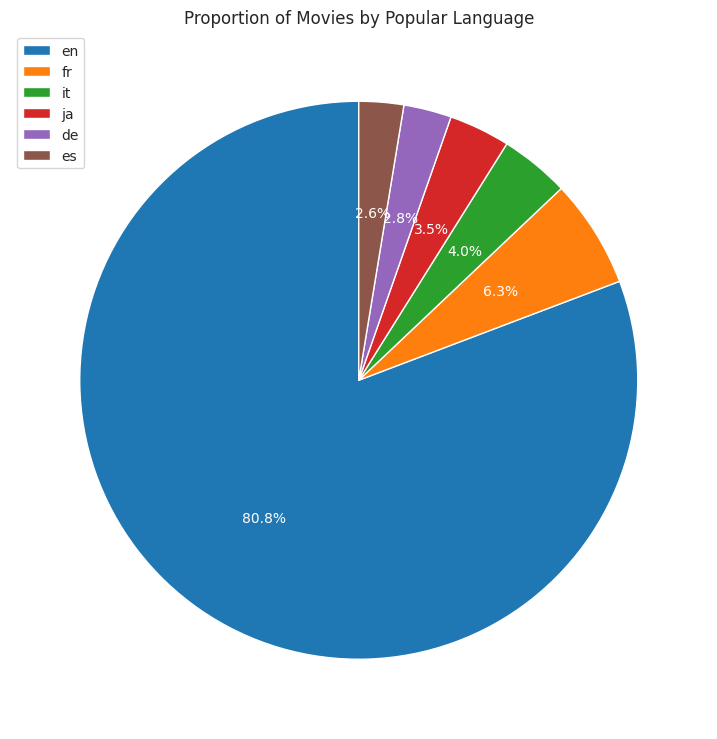

In [ ]:
language_counts = df['original_language'].value_counts()

# create a new dataframe with the language counts
language_df = pd.DataFrame({'language': language_counts.index, 'count': language_counts.values})

# calculate the percentage of movies by language
language_df['percent'] = 100 * language_df['count'] / language_df['count'].sum()


language_df = language_df[language_df['percent'] >= 1.9]
fig, ax = plt.subplots(figsize=(9, 10))

plt.rcParams['axes.facecolor'] = 'white'

plt.pie(language_df['count'], labels=None, autopct='%1.1f%%', startangle=90, textprops={'color': 'white'})


language_labels = [lang if percent >= 1.9 else '' for lang, percent in zip(language_df['language'], language_df['percent'])]
plt.legend(language_labels, loc='upper left')


plt.title('Proportion of Movies by Popular Language')

plt.show()

<Axes: title={'center': 'Correlation of Movie Features Using Pearson \n'}>

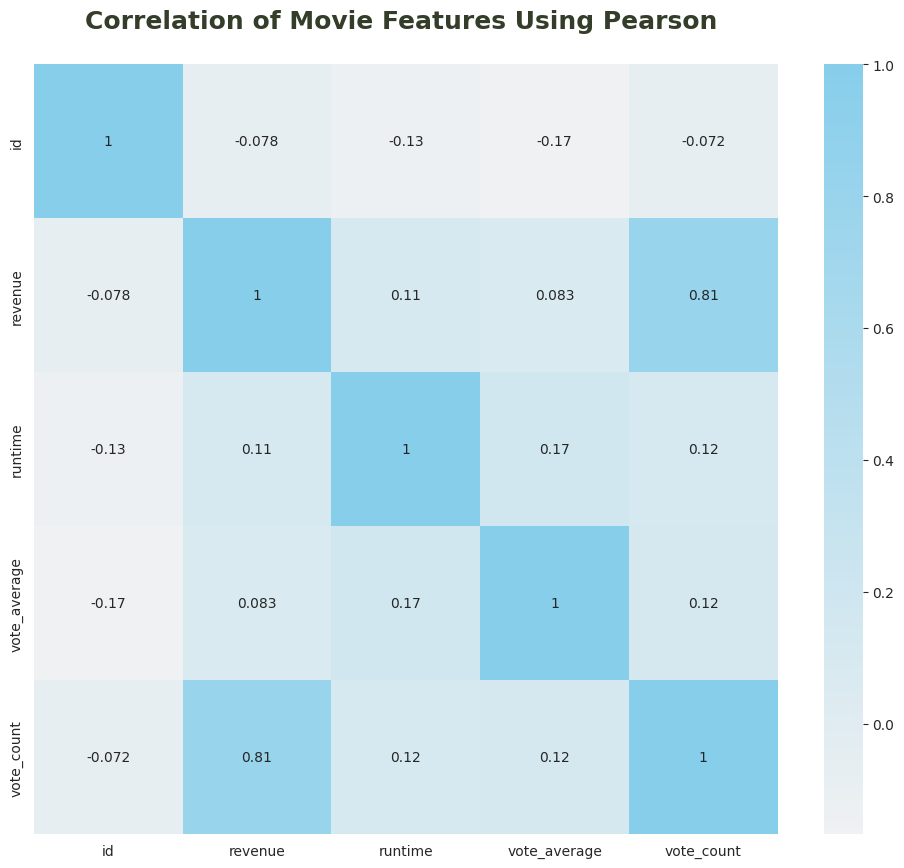

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features Using Pearson \n', fontsize=18, weight=600, color='#333d29')
cmap = sns.light_palette("skyblue", as_cmap=True)
corr_matrix_pearson = df.corr(method='pearson')
sns.heatmap(corr_matrix_pearson, annot=True, cmap = cmap)

<Axes: title={'center': 'Correlation of Movie Features Using Spearman \n'}>

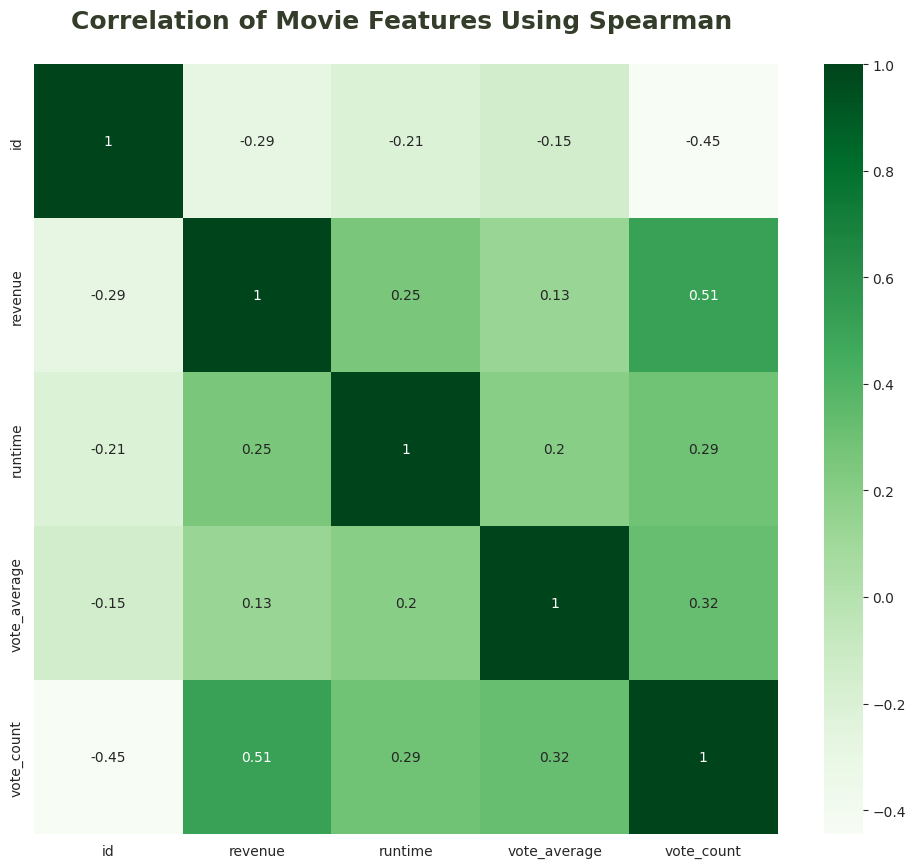

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features Using Spearman \n', fontsize=18, weight=600, color='#333d29')
cmap = sns.color_palette('Greens', as_cmap=True)
corr_matrix_spearman = df.corr(method='spearman')
sns.heatmap(corr_matrix_spearman , annot=True, cmap=cmap)


In [ ]:
ratings_df = pd.read_csv('ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genre_type', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genre_type,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,[Drama],"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"[Drama, History]",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"[Comedy, Romance]","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"[Comedy, Drama, Romance]",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,[Comedy],When Jay and Silent Bob learn that their comic...


In [ ]:
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

df = ratings_df

reader = Reader()

svd = SVD()

In [ ]:
df_movie_summary = df.groupby('movieId')['rating'].agg(['count','mean'])
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
df = df[~df['movieId'].isin(drop_movie_list)]
print(df_movie_summary)

         count      mean
movieId                 
2          107  3.401869
3           59  3.161017
5           56  3.267857
6          104  3.884615
11          82  3.689024
...        ...       ...
135536       1  3.000000
140174       5  3.900000
148652       1  2.500000
158238       2  3.750000
160718       1  4.000000

[2725 rows x 2 columns]


In [ ]:
def show_recommendation(userId):
  data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

  recommend = df_title.copy().reset_index()

  # fit trainset
  trainset = data.build_full_trainset()
  svd.fit(trainset)

  recommend['estimated_score'] = recommend['movieId'].apply(lambda x: svd.predict(userId, x).est)

  recommend = recommend.drop('movieId', axis = 1)
  recommend = recommend.sort_values('estimated_score', ascending=False)
  print(recommend.head(10))

In [ ]:
# Show recommendation

# For user id: 1
show_recommendation(1)

       index                                     original_title  \
334      334                            While You Were Sleeping   
534      534                               Sleepless in Seattle   
936      936                                       The 39 Steps   
662      662                                          Space Jam   
6090    6090                                         Straw Dogs   
3981    3981                           The Million Dollar Hotel   
24955  24955  Shriek If You Know What I Did Last Friday the ...   
2623    2623                            The Thomas Crown Affair   
11265  11265                                      Lonely Hearts   
286      286                                 Once Were Warriors   

       estimated_score  
334           4.056496  
534           4.030176  
936           4.011722  
662           4.008241  
6090          3.988806  
3981          3.986520  
24955         3.982848  
2623          3.978683  
11265         3.974616  
286         

In [ ]:
# Show recommendation

# For user id: 100
show_recommendation(100)

In [ ]:
# Show recommendation

# For user id: 555
show_recommendation(555)

       index                       original_title  estimated_score
3981    3981             The Million Dollar Hotel         4.245502
10005  10005                       Broken Flowers         4.112011
5234    5234                          5 Card Stud         4.018127
334      334              While You Were Sleeping         4.016916
936      936                         The 39 Steps         4.010920
6312    6312   Terminator 3: Rise of the Machines         3.999735
4095    4095                             Scarface         3.992927
5264    5264                      Men in Black II         3.977253
4793    4793  Le fabuleux destin d'Amélie Poulain         3.968947
534      534                 Sleepless in Seattle         3.959480


In [ ]:
df_pivot = pd.pivot_table(df, values='rating', index='userId',columns='movieId')
df_pivot.head(100)

movieId,2,3,5,6,11,12,14,15,16,17,...,85414,86332,88744,89492,93840,94959,96821,97938,104374,111759
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN
98,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def recommend_based_on_movie(movie_title):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['original_title'] == movie_title][0])
    target = df_pivot[i]
    similar_to_target = df_pivot.corrwith(target)
    # print(similar_to_target.head())

    # print('Target', target, 'Sim Traget', similar_to_target)

    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'original_title', 'count', 'mean']]
    print(corr_target[corr_target['count'] > 0][:10].sort_values(by=['count'], ascending = False).to_string(index=False))


In [ ]:
recommend_based_on_movie('The Million Dollar Hotel', 2)

For movie (The Million Dollar Hotel)
- Top 10 movies recommended based on Pearsons'R correlation - 


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


 PearsonR                            original_title  count     mean
      1.0                      Vanya on 42nd Street    114 3.350877
      1.0                                  Outbreak    107 3.336449
      1.0                                    Gandhi     95 3.784211
      1.0                        Alice's Restaurant     45 3.533333
      1.0 The Batman Superman Movie: World's Finest     37 3.851351
      1.0                         The Mummy's Ghost     35 4.100000
      1.0                             Keetje Tippel     31 3.241935
      1.0                          April Fool's Day     23 4.043478
      1.0                                   Starman     22 3.977273
      1.0                                     Gordy     15 2.933333


In [ ]:
recommend_based_on_movie("Batman", 0)

For movie (Batman)
- Top 10 movies recommended based on Pearsons'R correlation - 


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


         PearsonR
movieId          
41571         1.0
1892          1.0
7445          1.0
936           1.0
2648          1.0
 PearsonR                    original_title  count     mean
      1.0                            Batman     41 3.073171
      1.0                          Soapdish     30 3.583333
      1.0 El Bosco, el jardín de los sueños     29 3.793103
      1.0                 The Mask of Zorro     23 3.260870
      1.0                            Bedlam     23 3.391304
      1.0                    Penny Serenade     23 4.173913
      1.0                   Damien: Omen II     15 4.166667
      1.0                      The 39 Steps     13 3.692308
      1.0                          Stratton     11 3.318182
      1.0           Honey I Blew Up the Kid     11 4.636364
